In [1]:
from config import *
from qm.qua import *
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm import SimulationConfig
import time as time
import matplotlib.pyplot as plt
import numpy as np

qmm = QuantumMachinesManager(host='192.168.15.128',port=80)
qmm.close_all_quantum_machines()
qm = qmm.open_qm(config) #remember which config

2022-03-13 17:47:55,679 - qm - INFO - Performing health check
2022-03-13 17:47:55,683 - qm - INFO - Health check passed


Here I make a simple exchange pulse without changing parameters, the loop is for changing tau

In [2]:
little_up=0.2
duration_1=int(40e2)//4
readout_length=1000 #this matches config, in ns i think
tau_time=np.array([5e2])

ramp_target=0.2
ramp_time=int(40e2) #time in ns
ramp_rate=ramp_target/ramp_time

ramp_time_cycles=ramp_time//4
# tau=500
with program() as pulsing_seq:
    # tau = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    I_stream = declare_stream()
    Q_stream = declare_stream()
    tau = declare(int)
    i = declare(int)

    with for_(tau, 500, tau<500+0.5, tau+1):
        wait(duration_1)

        play(ramp(ramp_rate), 'Q1_L', duration=ramp_time_cycles) #first go down
        play(ramp(-ramp_rate), 'Q1_R', duration=ramp_time_cycles)
 
        wait(duration_1)
        play('CW'*amp(-little_up), 'Q1_L', duration=tau) #then jump up
        play('CW'*amp(little_up), 'Q1_R', duration=tau)
   

        play('CW'*amp(little_up), 'Q1_L', duration=duration_1) #jump back down
        play('CW'*amp(-little_up), 'Q1_R', duration=duration_1)
   
        
        #below ramp can be done by ramp_to_zero, but then we have to change the time in config, can perhaps be done above.
        play(ramp(-ramp_rate), 'Q1_L', duration=ramp_time_cycles) 
        play(ramp(ramp_rate), 'Q1_R', duration=ramp_time_cycles)

        align('Q1_readout','Q1_L','Q1_R')
        measure('readout_pulse_0_2', 'Q1_readout', None, demod.full('cos', I), demod.full('sin', Q))

        save(I, I_stream)
        save(Q, Q_stream)

    

    with stream_processing():
        I_stream.buffer(1).average().save('I')
        Q_stream.buffer(1).average().save('Q')



In [3]:
total_pulse_time=3*duration_1+2*ramp_time_cycles+tau_time+readout_length
job = qm.simulate(pulsing_seq, SimulationConfig(total_pulse_time))
samples = job.get_simulated_samples()
# samples.con1.plot()

2022-03-13 17:48:01,178 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2022-03-13 17:48:01,195 - qm - INFO - Flags: 
2022-03-13 17:48:01,196 - qm - INFO - Simulating program


C:\Users\T7\miniconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


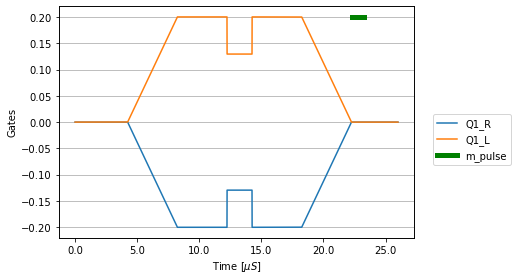

In [4]:
import matplotlib.pyplot as plt
meas_pulse=np.where(samples.con1.analog['1']!=0)
begin_meas=meas_pulse[0][0]
end_meas=meas_pulse[0][-1]

fig,ax=plt.subplots()
ax2=ax.twinx()
ax2.plot([begin_meas,end_meas],[1,1],label='m_pulse',c='green',linewidth=5)
ax.plot(samples.con1.analog['2'],label='Q1_R')
ax.plot(samples.con1.analog['3'],label='Q1_L')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Gates')
ax2.set_ylim(0,1.05)
ax2.yaxis.set_visible(False)
ax.grid(axis='y')

xticks=ax.get_xticks()
ax.set_xticklabels(xticks/1e3)
ax.set_xlabel(r'Time [$\mu S$]')
plt.tight_layout()

Below i want to make the same pulse but with varying tau and height of the square

In [9]:
# little_up=0.2
duration_1=int(40e2)//4
readout_length=1000 #this matches config, in ns i think
tau_time=np.array([5e2])

ramp_target=0.2
ramp_time=int(40e2) #time in ns
ramp_rate=ramp_target/ramp_time

ramp_time_cycles=ramp_time//4
# tau=500
with program() as pulsing_seq_map:

    I = declare(fixed)
    Q = declare(fixed)
    I_stream = declare_stream()
    Q_stream = declare_stream()
    tau = declare(int)
    E = declare(fixed)
    #averaging can be done at multiple steps, either take the entire map, and average over it, over a row or a single pixel
    with for_(E, 0.05, E<0.455, E+0.01): #size 41
        with for_(tau, 300, tau<700+0.5, tau+10): #size 41
            
            wait(duration_1)

            play(ramp(ramp_rate), 'Q1_L', duration=ramp_time_cycles) #first ramp down
            play(ramp(-ramp_rate), 'Q1_R', duration=ramp_time_cycles)
    
            wait(duration_1)
            play('CW'*amp(-E), 'Q1_L', duration=tau) #then jump up
            play('CW'*amp(E), 'Q1_R', duration=tau)
    
            #if pulses where sticky instead of elements this could be ommitted 
            play('CW'*amp(E), 'Q1_L', duration=duration_1) #jump back down
            play('CW'*amp(-E), 'Q1_R', duration=duration_1)
    
            
            #below ramp can be done by ramp_to_zero, but then we have to change the time in config, can perhaps be done above.
            play(ramp(-ramp_rate), 'Q1_L', duration=ramp_time_cycles) 
            play(ramp(ramp_rate), 'Q1_R', duration=ramp_time_cycles)

            align('Q1_readout','Q1_L','Q1_R')
            measure('readout_pulse_0_2', 'Q1_readout', None, demod.full('cos', I), demod.full('sin', Q))

            save(I, I_stream)
            save(Q, Q_stream)

    

    with stream_processing():
        I_stream.buffer(41,41).save('I')
        Q_stream.buffer(41,41).save('Q')


In [10]:
total_pulse_time=3*duration_1+2*ramp_time_cycles+tau_time+readout_length
job = qm.simulate(pulsing_seq_map, SimulationConfig(41*total_pulse_time))
samples = job.get_simulated_samples()

2022-03-14 09:30:48,612 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2022-03-14 09:30:48,631 - qm - INFO - Flags: 
2022-03-14 09:30:48,632 - qm - INFO - Simulating program


C:\Users\T7\miniconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


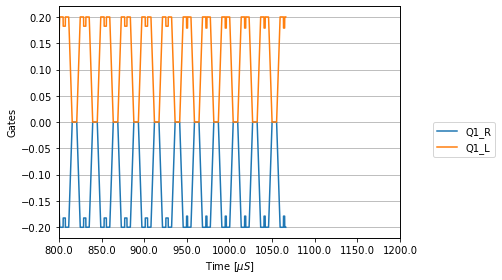

In [25]:
import matplotlib.pyplot as plt
meas_pulse=np.where(samples.con1.analog['1']!=0)
begin_meas=meas_pulse[0][0]
end_meas=meas_pulse[0][-1]

fig,ax=plt.subplots()
ax2=ax.twinx()
# ax2.plot([begin_meas,end_meas],[1,1],label='m_pulse',c='green',linewidth=5)
ax.plot(samples.con1.analog['2'],label='Q1_R')
ax.plot(samples.con1.analog['3'],label='Q1_L')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Gates')
ax2.set_ylim(0,1.05)
ax2.yaxis.set_visible(False)
ax.grid(axis='y')


ax.set_xlabel(r'Time [$\mu S$]')
ax.set_xlim(int(800e3),int(1200e3))
xticks=ax.get_xticks()
ax.set_xticklabels(xticks/1e3)
plt.tight_layout()

400000